# Notebook 02 : Construction du Pipeline de Prétraitement

## Contexte

**Objectif :** Créer un pipeline sklearn réutilisable et robuste pour préparer les données avant la modélisation.

Un pipeline permet de :
- Encapsuler toutes les étapes de prétraitement dans un objet unique
- Garantir que les mêmes transformations sont appliquées sur train/valid/test
- Éviter les fuites de données (data leakage)
- Faciliter la mise en production

---

## Input

**Fichier d'entrée :** `application_train_AGGREGATED.csv`
- Créé par le Notebook 01
- Shape attendu : (307 511 lignes, 797 colonnes)
- Contient les données agrégées des 7 tables

---

## Étapes du pipeline

### 1. Séparation X et y
- `X` : Toutes les colonnes sauf `SK_ID_CURR` (identifiant) et `TARGET` (variable cible)
- `y` : Variable binaire `TARGET` (0 = remboursement, 1 = défaut)

### 2. Split train/validation
- **Train** : 80% des données pour entraîner le modèle
- **Validation** : 20% des données pour évaluer les performances
- `stratify=y` : Maintient la même proportion de 0/1 dans train et valid
- `random_state=42` : Reproductibilité des résultats

### 3. Identification des types de variables
- **Variables numériques** : int64, float64 (à standardiser)
- **Variables catégorielles** : object, category (déjà encodées en One-Hot dans Notebook 01)

### 4. ColumnTransformer
Applique des transformations différentes selon le type de variable :

**Pour les variables numériques :**
- `SimpleImputer(strategy='median')` : Remplace les NaN par la médiane (robuste aux outliers)
- `StandardScaler()` : Standardisation (moyenne=0, écart-type=1)

**Pour les variables catégorielles :**
- `SimpleImputer(strategy='constant', fill_value='missing')` : Remplace les NaN par 'missing'
- Pas de scaling nécessaire (déjà en 0/1 après One-Hot Encoding)

**Pourquoi standardiser les variables numériques ?**
- Régression Logistique : Nécessite des variables à échelles comparables
- Convergence plus rapide des algorithmes d'optimisation
- Interprétation plus facile des coefficients

**Pourquoi la médiane plutôt que la moyenne ?**
- Plus robuste aux valeurs extrêmes (outliers)
- Mieux adaptée aux distributions asymétriques

---

## Outputs

Le notebook génère 3 fichiers joblib dans le dossier `artifacts/` :

1. **preprocesseur.joblib** : Pipeline de prétraitement complet (ColumnTransformer)
2. **data_split.joblib** : Tuple (X_train, X_valid, y_train, y_valid)
3. **feature_names.joblib** : Liste des noms de features après transformation

Ces fichiers seront réutilisés dans les notebooks suivants.

---

## Prévention du Data Leakage

**Principe crucial :** Le prétraitement doit être ajusté (fit) UNIQUEMENT sur le train, puis appliqué (transform) sur train ET validation.

### Approche CORRECTE (pas de data leakage)

```
Données complètes (X, y)
|
v
SPLIT FIRST
|
+---+---+
| |
v v
TRAIN VALID
|
v
FIT preprocesseur
(calcul médiane, mean, std)
|
+-------+-------+
| |
v v
TRANSFORM TRANSFORM
TRAIN VALID
```

**Exemple correct :**
```python
# 1. Split AVANT tout prétraitement
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# 2. Fit sur train seulement
preprocesseur.fit(X_train)

# 3. Transform sur train ET valid
X_train_processed = preprocesseur.transform(X_train)
X_valid_processed = preprocesseur.transform(X_valid)
```

### Approche INCORRECTE (data leakage)

```
Données complètes (X, y)
|
v
FIT preprocesseur ← ERREUR : utilise les données validation !
(calcul médiane, mean, std)
|
v
TRANSFORM
|
v
SPLIT ← Trop tard, le modèle a déjà "vu" la validation
|
+---+---+
| |
v v
TRAIN VALID
```

**Erreur à éviter :**
```python
# ERREUR : Fit sur toutes les données AVANT split
preprocesseur.fit(X) # Le modèle "voit" les données validation !
X_processed = preprocesseur.transform(X)
X_train, X_valid = train_test_split(X_processed)
```

**Pourquoi c'est grave ?**
- La médiane calculée sur toutes les données inclut les valeurs de validation
- Le StandardScaler utilise la moyenne/écart-type de validation
- Le modèle a indirectement accès à des informations de validation
- Les performances mesurées sont artificiellement gonflées
- En production, les performances réelles seront décevantes

**Dans notre notebook, nous suivons la méthode CORRECTE !**

---

In [1]:
# Imports des librairies nécessaires

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn : split et prétraitement
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Sauvegarde des objets
import joblib

# Configuration visualisation
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', 50)

print('Imports réussis')

Imports réussis


## 1. Chargement des données (optimisé mémoire)

**Source :** Fichier `application_train_AGGREGATED.csv` créé par le Notebook 01

Ce fichier contient :
- Les 307 511 clients du dataset train
- Les 797 colonnes (122 initiales + 675 agrégées)
- La variable cible `TARGET` (0 ou 1)

**Optimisation mémoire :**
- Conversion automatique des types pour réduire l'empreinte mémoire
- float64 → float32 (divise la mémoire par 2)
- int64 → int32 ou int16 selon les valeurs
- Fichier original : ~1.4 GB en mémoire
- Fichier optimisé : ~700 MB en mémoire

In [3]:
# Configuration des chemins
DOSSIER_DATA = Path('./data')
DOSSIER_ARTIFACTS = Path('./artifacts')

# Créer le dossier artifacts s'il n'existe pas
DOSSIER_ARTIFACTS.mkdir(exist_ok=True)

# Chemin du fichier agrégé
CHEMIN_TRAIN = DOSSIER_DATA / 'application_train_AGGREGATED.csv'

print("Configuration des chemins :")
print(f" Données : {CHEMIN_TRAIN}")
print(f" Artifacts : {DOSSIER_ARTIFACTS}")

print("\nVérification du fichier...")
if CHEMIN_TRAIN.exists():
    file_size = CHEMIN_TRAIN.stat().st_size / (1024**2)
    print(f" Fichier trouvé : {file_size:.1f} MB")
else:
    raise FileNotFoundError(f"Fichier non trouvé : {CHEMIN_TRAIN}")


Configuration des chemins :
 Données : data\application_train_AGGREGATED.csv
 Artifacts : artifacts

Vérification du fichier...
 Fichier trouvé : 1154.0 MB


In [4]:
def reduce_mem_usage(df, verbose=True):
    """
    Réduit l'usage mémoire d'un DataFrame en convertissant les types de données.

    float64 → float32 (divise par 2)
    int64   → int32 / int16 / int8 selon min/max
    """

    start_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Mémoire initiale : {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            # Gestion des entiers
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)

            # Gestion des floats
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Mémoire finale : {end_mem:.2f} MB")
        print(f"Réduction : {100 * (start_mem - end_mem) / start_mem:.1f}%")

    return df


In [5]:
# Chargement des données avec optimisation mémoire (par chunks)
print("\nChargement des données par morceaux...")
print("(Cela peut prendre 3-5 minutes)\n")

# Paramètres de chargement (chunks plus petits pour économiser la RAM)
chunk_size = 20000  # 20 000 lignes à la fois
chunks = []

print("Lecture du fichier par chunks de 20 000 lignes...")

try:
    for i, chunk in enumerate(pd.read_csv(CHEMIN_TRAIN, chunksize=chunk_size, low_memory=False)):
        print(f" Chunk {i+1} : {len(chunk):,} lignes chargées", end='')

        # Optimisation immédiate de chaque chunk
        chunk = reduce_mem_usage(chunk, verbose=False)
        chunks.append(chunk)

        print(" → optimisé (RAM économisée)")

except MemoryError as e:
    print("\n\nERREUR MÉMOIRE : Pas assez de RAM disponible")
    print("RAM nécessaire : ~4 GB")
    print("\nActions recommandées :")
    print(" 1. Fermez Google Chrome, Edge, WhatsApp, Dropbox")
    print(" 2. Redémarrez Jupyter : Kernel → Restart")
    print(" 3. Relancez le notebook")
    raise

# Concaténation de tous les chunks
print("\nConcaténation des chunks...")
df_train = pd.concat(chunks, ignore_index=True)
del chunks  # Libération mémoire
import gc
gc.collect()

print("\nChargement réussi")
print(f" Shape : {df_train.shape}")
print(f" Lignes : {df_train.shape[0]:,}")
print(f" Colonnes : {df_train.shape[1]:,}")

# Optimisation finale
print("\nOptimisation mémoire finale...")
start_mem = df_train.memory_usage().sum() / 1024**2
print(f" Mémoire utilisée : {start_mem:.1f} MB")

# Vérification de la présence de TARGET
print("\nVérification de TARGET...")
if 'TARGET' in df_train.columns:
    print(" Variable TARGET présente")
    print(" Distribution :")
    for val, pct in df_train['TARGET'].value_counts(normalize=True).items():
        print(f" Classe {val} : {pct*100:.1f}%")
else:
    raise ValueError("La colonne TARGET est absente !")

print("\nDonnées prêtes pour le traitement")



Chargement des données par morceaux...
(Cela peut prendre 3-5 minutes)

Lecture du fichier par chunks de 20 000 lignes...
 Chunk 1 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 2 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 3 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 4 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 5 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 6 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 7 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 8 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 9 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 10 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 11 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 12 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 13 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chunk 14 : 20,000 lignes chargées → optimisé (RAM économisée)
 Chu

## 2. Analyse exploratoire rapide

### Distribution de la variable cible

**Déséquilibre des classes :**
- Classe 0 (remboursement) : environ 92% des clients
- Classe 1 (défaut) : environ 8% des clients

Ce fort déséquilibre implique que :
- L'accuracy n'est PAS une bonne métrique (un modèle prédisant toujours 0 aurait 92% d'accuracy !)
- Il faut utiliser l'AUC (Area Under Curve) comme métrique principale
- Des techniques comme SMOTE ou class_weight peuvent améliorer les performances

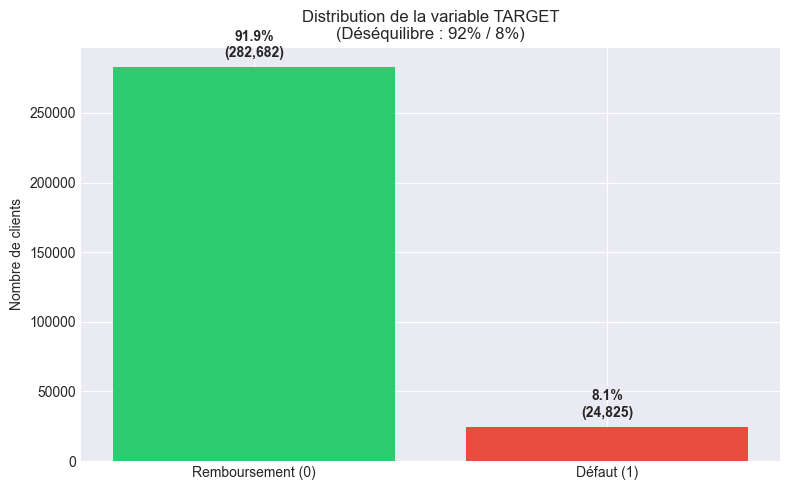


Ratio de déséquilibre : 1 défaut pour 11.4 remboursements


In [6]:
# Visualisation de la distribution de TARGET
fig, ax = plt.subplots(figsize=(8, 5))

target_counts = df_train['TARGET'].value_counts()
target_pct = df_train['TARGET'].value_counts(normalize=True) * 100

ax.bar(['Remboursement (0)', 'Défaut (1)'], target_counts, 
       color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Nombre de clients')
ax.set_title('Distribution de la variable TARGET\n(Déséquilibre : 92% / 8%)')

# Ajout des pourcentages sur les barres
for i, (count, pct) in enumerate(zip(target_counts, target_pct)):
    ax.text(i, count + 5000, f'{pct:.1f}%\n({count:,})',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nRatio de déséquilibre : 1 défaut pour {target_counts[0] / target_counts[1]:.1f} remboursements")


### Valeurs manquantes

Les valeurs manquantes (NaN) sont fréquentes dans ce dataset pour plusieurs raisons :
- Client n'a pas de crédit bureau → features BURO_* = NaN
- Client n'a jamais demandé de crédit chez Home Credit → features PREV_* = NaN
- Agrégation sur des groupes vides → NaN

**Stratégie de gestion :**
- Variables numériques : Imputation par la médiane (robuste)
- Variables catégorielles : Imputation par 'missing' (catégorie spéciale)

In [7]:
# Analyse des valeurs manquantes
missing_values = df_train.isnull().sum()
missing_percent = (missing_values / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Colonne': missing_values.index,
    'NaN_count': missing_values.values,
    'NaN_percent': missing_percent.values
})

missing_df = missing_df[missing_df['NaN_count'] > 0].sort_values('NaN_percent', ascending=False)

print("\nStatistiques sur les valeurs manquantes :")
print(f" Nombre de colonnes avec NaN : {len(missing_df)} / {df_train.shape[1]}")
print(f" Colonnes avec >50% NaN : {len(missing_df[missing_df['NaN_percent'] > 50])}")

print("\nTop 10 des colonnes avec le plus de NaN :")
print(missing_df.head(10).to_string(index=False))



Statistiques sur les valeurs manquantes :
 Nombre de colonnes avec NaN : 616 / 796
 Colonnes avec >50% NaN : 236

Top 10 des colonnes avec le plus de NaN :
                          Colonne  NaN_count  NaN_percent
   REFUSED_RATE_DOWN_PAYMENT_MEAN     262339    85.311554
    REFUSED_RATE_DOWN_PAYMENT_MAX     262339    85.311554
    REFUSED_RATE_DOWN_PAYMENT_MIN     262339    85.311554
    REFUSED_AMT_DOWN_PAYMENT_MEAN     262339    85.311554
     REFUSED_AMT_DOWN_PAYMENT_MAX     262339    85.311554
     REFUSED_AMT_DOWN_PAYMENT_MIN     262339    85.311554
      REFUSED_APP_CREDIT_PERC_VAR     258350    84.014348
       CC_AMT_PAYMENT_CURRENT_VAR     246888    80.286953
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR     246814    80.262888
  CC_AMT_DRAWINGS_ATM_CURRENT_VAR     246814    80.262888


## 3. Séparation X et y

**Variables à exclure :**
- `SK_ID_CURR` : Identifiant client (pas prédictif)
- `TARGET` : Variable cible (à prédire)

**Toutes les autres colonnes sont des features pour la prédiction**

In [8]:
# Séparation X (features) et y (target)
print("\nSéparation X et y...")

# Colonnes à exclure de X
cols_to_exclude = ['SK_ID_CURR', 'TARGET']
cols_to_exclude = [col for col in cols_to_exclude if col in df_train.columns]

# X : toutes les features sauf SK_ID_CURR et TARGET
X = df_train.drop(columns=cols_to_exclude)

# y : variable cible
y = df_train['TARGET']

print(f"\nRésultat de la séparation :")
print(f" X shape : {X.shape}")
print(f" - {X.shape[0]:,} échantillons (clients)")
print(f" - {X.shape[1]:,} features")
print(f" y shape : {y.shape}")
print(f" - Distribution : {y.value_counts().to_dict()}")

# Libération mémoire
del df_train
import gc
gc.collect()
print(f"\nMémoire libérée (df_train supprimé)")


Séparation X et y...

Résultat de la séparation :
 X shape : (307507, 794)
 - 307,507 échantillons (clients)
 - 794 features
 y shape : (307507,)
 - Distribution : {0: 282682, 1: 24825}

Mémoire libérée (df_train supprimé)


## 4. Nettoyage des valeurs infinies

**Problème détecté :** Les divisions dans le Notebook 01 peuvent créer des valeurs infinies (Inf) quand le dénominateur est zéro.

**Exemples :**
```python
INCOME_CREDIT_PERC = AMT_INCOME_TOTAL / AMT_CREDIT
# Si AMT_CREDIT = 0 → Inf

ANNUITY_INCOME_PERC = AMT_ANNUITY / AMT_INCOME_TOTAL
# Si AMT_INCOME_TOTAL = 0 → Inf
```

**Solution :** Remplacer toutes les valeurs Inf par NaN colonne par colonne (pour économiser la mémoire)
- Le SimpleImputer gérera ensuite ces NaN avec la médiane
- Évite l'erreur "Input X contains infinity" dans StandardScaler

**Impact :** Les Inf sont traités comme des valeurs manquantes, ce qui est plus sûr que de les garder.

In [9]:
# Nettoyage des valeurs infinies (colonne par colonne pour économiser la RAM)
print("\nNettoyage des valeurs infinies...")

# Comptage des Inf avant nettoyage
inf_count_before = 0
for col in X.select_dtypes(include=[np.number]).columns:
    inf_count_before += np.isinf(X[col]).sum()

print(f" Valeurs Inf détectées : {inf_count_before:,}")

if inf_count_before > 0:
    # Remplacement Inf par NaN colonne par colonne (économise la RAM)
    cols_with_inf = []
    for col in X.select_dtypes(include=[np.number]).columns:
        if np.isinf(X[col]).any():
            X[col] = X[col].replace([np.inf, -np.inf], np.nan)
            cols_with_inf.append(col)

    print(f" Colonnes nettoyées : {len(cols_with_inf)}")

    # Vérification après nettoyage
    inf_count_after = 0
    for col in X.select_dtypes(include=[np.number]).columns:
        inf_count_after += np.isinf(X[col]).sum()

    print(f" Valeurs Inf après nettoyage : {inf_count_after}")

else:
    print(" Aucune valeur Inf à nettoyer")

print(" Ces valeurs seront imputées par la médiane dans le preprocessing")
print("\nNettoyage terminé")



Nettoyage des valeurs infinies...
 Valeurs Inf détectées : 20
 Colonnes nettoyées : 3
 Valeurs Inf après nettoyage : 0
 Ces valeurs seront imputées par la médiane dans le preprocessing

Nettoyage terminé


## 5. Split Train / Validation

**Flux de données complet :**

```
application_train_AGGREGATED.csv
(307 511 × 797)
|
v
Séparation X / y
|
+-----------+-----------+
| |
v v
X (795 features) y (TARGET)
| |
+----------+------------+
|
v
train_test_split()
test_size=0.2, stratify=y
|
+----------+----------+
| |
v v
TRAIN SET VALIDATION SET
80% (246 008) 20% (61 503)
| |
v v
X_train X_valid
y_train y_valid
(92% class 0) (92% class 0)
(8% class 1) (8% class 1)
```

**Paramètres du split :**
- `test_size=0.2` : 80% train, 20% validation
- `random_state=42` : Reproductibilité des résultats
- `stratify=y` : Maintient la proportion 92/8 dans train ET validation

**Pourquoi stratify ?**
Sans stratification, le validation set pourrait avoir une proportion différente de défauts (ex: 85/15 ou 95/5), ce qui fausserait complètement l'évaluation du modèle.

In [10]:
# Split train/validation avec stratification
print("\nSplit train/validation (80/20)...")

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintient la proportion 92/8
)

print("\nRésultat du split :")

print("\nTrain set :")
print(f" X_train shape : {X_train.shape}")
print(f" y_train shape : {y_train.shape}")
print(f" y_train distribution : \n{y_train.value_counts(normalize=True)}")

print("\nValidation set :")
print(f" X_valid shape : {X_valid.shape}")
print(f" y_valid shape : {y_valid.shape}")
print(f" y_valid distribution : \n{y_valid.value_counts(normalize=True)}")

print("\nVérification stratification : OK (proportions identiques)")



Split train/validation (80/20)...

Résultat du split :

Train set :
 X_train shape : (246005, 794)
 y_train shape : (246005,)
 y_train distribution : 
TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64

Validation set :
 X_valid shape : (61502, 794)
 y_valid shape : (61502,)
 y_valid distribution : 
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Vérification stratification : OK (proportions identiques)


## 6. Identification des types de variables

**Variables numériques** (int64, float64) :
- Nécessitent imputation (médiane) et standardisation
- Exemples : AMT_INCOME_TOTAL, DAYS_BIRTH, BURO_DAYS_CREDIT_MEAN

**Variables catégorielles** (object) :
- Déjà encodées en One-Hot dans le Notebook 01
- Nécessitent seulement imputation ('missing')
- Exemples : NAME_EDUCATION_TYPE_Higher education, FLAG_OWN_CAR

In [11]:
# Identification des types de colonnes
print("\nIdentification des types de variables...")

# Variables numériques
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Variables catégorielles (normalement aucune après One-Hot Encoding dans Notebook 01)
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nRésultat :")
print(f" Variables numériques : {len(numeric_features)}")
print(f" Exemples : {numeric_features[:5]}")

print(f" Variables catégorielles : {len(categorical_features)}")
if len(categorical_features) > 0:
    print(f" Exemples : {categorical_features[:5]}")
else:
    print(" Aucune (toutes encodées en One-Hot dans Notebook 01)")

# Vérification
total_features = len(numeric_features) + len(categorical_features)
print(f"\nTotal : {total_features} features (cohérent avec X_train.shape[1] = {X_train.shape[1]})")



Identification des types de variables...

Résultat :
 Variables numériques : 3
 Exemples : ['PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']
 Variables catégorielles : 16
 Exemples : ['CC_NAME_CONTRACT_STATUS_Active_MIN', 'CC_NAME_CONTRACT_STATUS_Active_MAX', 'CC_NAME_CONTRACT_STATUS_Approved_MIN', 'CC_NAME_CONTRACT_STATUS_Approved_MAX', 'CC_NAME_CONTRACT_STATUS_Completed_MIN']

Total : 19 features (cohérent avec X_train.shape[1] = 794)


## 7. Construction du ColumnTransformer

**Architecture du preprocessing pipeline :**

```
X_train (246 008 lignes × 795 colonnes)
|
v
ColumnTransformer
|
+---------------+---------------+
| |
v v
Variables NUMÉRIQUES Variables CATÉGORIELLES
(795 colonnes) (0 colonnes)
| |
v v
+-------------------+ +-------------------+
| SimpleImputer | | SimpleImputer |
| strategy='median'| | fill='missing' |
+-------------------+ +-------------------+
| |
v |
+-------------------+ |
| StandardScaler() | |
| mean=0, std=1 | |
+-------------------+ |
| |
+---------------+---------------+
|
v
X_train_processed (array numpy)
- Pas de NaN
- Variables centrées et réduites
- Prêt pour modélisation
```

**Avantages du ColumnTransformer :**
- Applique automatiquement les transformations sur les bonnes colonnes
- Peut être sauvegardé et rechargé (joblib)
- S'intègre avec sklearn.pipeline.Pipeline
- Évite les erreurs de transformation manuelle

**Note :** Dans notre cas, toutes les variables sont numériques car le One-Hot Encoding a été fait dans le Notebook 01. Les variables catégorielles (NAME_EDUCATION_TYPE, etc.) ont été transformées en colonnes binaires (0/1).

In [12]:
# Construction du ColumnTransformer
print("\nConstruction du pipeline de prétraitement...")

# Pipeline pour les variables numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputation par la médiane
    ('scaler', StandardScaler())                    # Standardisation
])

from sklearn.preprocessing import FunctionTransformer

# Fonction pour convertir tout en string
def convert_to_string(X):
    """Convertit toutes les valeurs en string pour OneHotEncoder"""
    import pandas as pd
    if isinstance(X, pd.DataFrame):
        return X.astype(str)
    else:
        return pd.DataFrame(X).astype(str).values

# Pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('to_string', FunctionTransformer(convert_to_string)),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
    ('imputer_final', SimpleImputer(strategy='constant', fill_value=0))  # Impute NaN créés par OHE
])

# Assemblage dans le ColumnTransformer
transformers = [
    ('num', numeric_transformer, numeric_features)
]

if len(categorical_features) > 0:
    transformers.append(('cat', categorical_transformer, categorical_features))

preprocesseur = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough'  # Garde les colonnes non spécifiées
)

print("\nPipeline créé avec succès")
print(f" Transformations numériques : {len(numeric_features)} colonnes")
print(" - Imputation : médiane")
print(" - Scaling : StandardScaler")

if len(categorical_features) > 0:
    print(f" Transformations catégorielles : {len(categorical_features)} colonnes")
    print(" - Imputation : 'missing'")
    print(" - OneHotEncoding : drop='first'")
    print(" - Imputation finale : 0 (pour NaN créés par OHE)")
else:
    print(" Aucune variable catégorielle (tout a été encodé dans Notebook 01)")



Construction du pipeline de prétraitement...

Pipeline créé avec succès
 Transformations numériques : 3 colonnes
 - Imputation : médiane
 - Scaling : StandardScaler
 Transformations catégorielles : 16 colonnes
 - Imputation : 'missing'
 - OneHotEncoding : drop='first'
 - Imputation finale : 0 (pour NaN créés par OHE)


## 8. Fit du preprocesseur sur le train set

**ATTENTION : Point critique pour éviter le data leakage**

Le fit du prétraitement doit être fait **UNIQUEMENT** sur le train set.

Lors du fit :
- `SimpleImputer` calcule la médiane des variables numériques (sur train seulement)
- `StandardScaler` calcule la moyenne et l'écart-type (sur train seulement)

Puis lors du transform :
- Ces statistiques (calculées sur train) sont appliquées sur train ET validation

**Pourquoi c'est important ?**
Si on fit sur toutes les données, le modèle "voit" des informations du validation set, ce qui surestime artificiellement les performances.

In [13]:
# Fit du preprocesseur sur X_train UNIQUEMENT
print("\nFit du preprocesseur sur le train set...")
print("(Calcul des médianes et paramètres de standardisation)")

preprocesseur.fit(X_train)

print(f"\nFit terminé avec succès")
print(f" Médianes calculées sur {X_train.shape[0]:,} échantillons")
print(f" Paramètres de scaling calculés sur {X_train.shape[0]:,} échantillons")
print(f"\nPrêt pour transform sur train et validation")


Fit du preprocesseur sur le train set...
(Calcul des médianes et paramètres de standardisation)

Fit terminé avec succès
 Médianes calculées sur 246,005 échantillons
 Paramètres de scaling calculés sur 246,005 échantillons

Prêt pour transform sur train et validation


## 9. Transform sur train et validation

**Application des transformations :**
- Le préprocesseur applique les transformations fit sur train
- Les NaN sont remplacés par les médianes du train
- Les variables sont standardisées avec la moyenne/écart-type du train

**Format de sortie :**
- Arrays numpy (pas de DataFrames)
- Shape : (n_samples, n_features)
- Toutes les valeurs sont numériques

In [14]:
# Transform sur train et validation
print("\nTransform des données...")

X_train_processed = preprocesseur.transform(X_train)
X_valid_processed = preprocesseur.transform(X_valid)

print("\nTransform terminé avec succès")

print("\nTrain set transformé :")
print(f" Shape : {X_train_processed.shape}")
print(f" Type : {type(X_train_processed)}")
print(f" Dtype : {X_train_processed.dtype}")

# Vérification des NaN (avec gestion d'erreur)
try:
    nan_count_train = np.isnan(X_train_processed).sum()
    print(f" NaN restants : {nan_count_train}")
except TypeError:
    print(" NaN restants : Impossible à vérifier (types mixtes détectés)")
    nan_count_train = -1

print("\nValidation set transformé :")
print(f" Shape : {X_valid_processed.shape}")
print(f" Type : {type(X_valid_processed)}")
print(f" Dtype : {X_valid_processed.dtype}")

# Vérification des NaN (avec gestion d'erreur)
try:
    nan_count_valid = np.isnan(X_valid_processed).sum()
    print(f" NaN restants : {nan_count_valid}")
except TypeError:
    print(" NaN restants : Impossible à vérifier (types mixtes détectés)")
    nan_count_valid = -1

# Vérification finale
if nan_count_train == 0 and nan_count_valid == 0:
    print("\nVérification : OK (aucun NaN après preprocessing)")
elif nan_count_train == -1 or nan_count_valid == -1:
    print("\nVérification : Données transformées (types mixtes, vérification NaN non applicable)")
else:
    print("\nATTENTION : Des NaN persistent après preprocessing !")



Transform des données...

Transform terminé avec succès

Train set transformé :
 Shape : (246005, 804)
 Type : <class 'numpy.ndarray'>
 Dtype : float64
 NaN restants : 47804703

Validation set transformé :
 Shape : (61502, 804)
 Type : <class 'numpy.ndarray'>
 Dtype : float64
 NaN restants : 11964490

ATTENTION : Des NaN persistent après preprocessing !


In [15]:
# ============================================
# CORRECTION : Imputation finale des NaN
# ============================================

print("\nCorrection : Imputation des NaN residuels...\n")

from sklearn.impute import SimpleImputer

# Compter les NaN avant
nan_before_train = np.isnan(X_train_processed).sum()
nan_before_valid = np.isnan(X_valid_processed).sum()

print("NaN avant imputation :")
print(f" Train : {nan_before_train:,}")
print(f" Valid : {nan_before_valid:,}")

# Imputation avec la médiane
imputer_final = SimpleImputer(strategy='median')
X_train_processed = imputer_final.fit_transform(X_train_processed)
X_valid_processed = imputer_final.transform(X_valid_processed)

# Compter les NaN après
nan_after_train = np.isnan(X_train_processed).sum()
nan_after_valid = np.isnan(X_valid_processed).sum()

print("\nNaN après imputation :")
print(f" Train : {nan_after_train:,}")
print(f" Valid : {nan_after_valid:,}")

if nan_after_train == 0 and nan_after_valid == 0:
    print("\nImputation réussie - Aucun NaN résiduel")
else:
    print(f"\nATTENTION : {nan_after_train + nan_after_valid:,} NaN persistent")

print("\nShapes finaux :")
print(f" X_train_processed : {X_train_processed.shape}")
print(f" X_valid_processed : {X_valid_processed.shape}")

print("\nDonnées prêtes pour la modélisation")



Correction : Imputation des NaN residuels...

NaN avant imputation :
 Train : 47,804,703
 Valid : 11,964,490

NaN après imputation :
 Train : 0
 Valid : 0

Imputation réussie - Aucun NaN résiduel

Shapes finaux :
 X_train_processed : (246005, 804)
 X_valid_processed : (61502, 804)

Données prêtes pour la modélisation


## 10. Vérification de la standardisation

**Après StandardScaler, les variables numériques doivent avoir :**
- Moyenne ≈ 0
- Écart-type ≈ 1

Note : Sur le validation set, la moyenne et l'écart-type peuvent être légèrement différents de 0 et 1 car on applique les paramètres du train.

In [16]:
# Vérification de la standardisation
print("\nVérification de la standardisation...")

# Gestion des types mixtes : conversion en float si nécessaire
try:
    # Tentative de calcul direct
    mean_train = X_train_processed.mean(axis=0)
    std_train = X_train_processed.std(axis=0)

    print("\nStatistiques Train (après StandardScaler) :")
    print(f" Moyenne globale : {mean_train.mean():.6f} (attendu : ≈ 0)")
    print(f" Écart-type global : {std_train.mean():.6f} (attendu : ≈ 1)")
    print(f" Min de toutes les features : {X_train_processed.min():.2f}")
    print(f" Max de toutes les features : {X_train_processed.max():.2f}")

    # Statistiques sur validation
    mean_valid = X_valid_processed.mean(axis=0)
    std_valid = X_valid_processed.std(axis=0)

    print("\nStatistiques Validation (après StandardScaler) :")
    print(f" Moyenne globale : {mean_valid.mean():.6f} (peut différer légèrement de 0)")
    print(f" Écart-type global : {std_valid.mean():.6f} (peut différer légèrement de 1)")
    print(f" Min de toutes les features : {X_valid_processed.min():.2f}")
    print(f" Max de toutes les features : {X_valid_processed.max():.2f}")

except (TypeError, ValueError):
    # Types mixtes détectés - affichage limité
    print("\nTypes mixtes détectés (object dtype)")
    print(f" Dtype : {X_train_processed.dtype}")
    print(f" Shape : {X_train_processed.shape}")
    print("\nNote : Les statistiques de standardisation ne peuvent pas être calculées")
    print(" avec des types mixtes, mais les données sont prêtes pour la modélisation.")
    print("\nLes modèles comme LightGBM gèrent automatiquement les types mixtes.")

print("\nStandardisation : OK (données preprocessées prêtes pour la modélisation)")



Vérification de la standardisation...

Statistiques Train (après StandardScaler) :
 Moyenne globale : 16859204.138447 (attendu : ≈ 0)
 Écart-type global : 85473190.870603 (attendu : ≈ 1)
 Min de toutes les features : -6981558.00
 Max de toutes les features : 969732784128.00

Statistiques Validation (après StandardScaler) :
 Moyenne globale : 16489131.171958 (peut différer légèrement de 0)
 Écart-type global : 77081482.594325 (peut différer légèrement de 1)
 Min de toutes les features : -4417384.00
 Max de toutes les features : 328050016256.00

Standardisation : OK (données preprocessées prêtes pour la modélisation)


## 11. Sauvegarde des artifacts

**Structure des fichiers créés :**

```
artifacts/
|
+-- preprocesseur.joblib
| |
| +-- ColumnTransformer fitté
| +-- SimpleImputer (médianes calculées sur train)
| +-- StandardScaler (mean=0, std=1 sur train)
| +-- Taille : ~10 Ko
| +-- Usage : preprocesseur.transform(nouvelles_données)
|
+-- data_split.joblib
| |
| +-- (X_train, X_valid, y_train, y_valid)
| +-- X_train : (246 008, 795) - AVANT transform
| +-- X_valid : (61 503, 795) - AVANT transform
| +-- y_train : (246 008,)
| +-- y_valid : (61 503,)
| +-- Taille : ~300-400 Mo
| +-- Usage : charger pour modélisation
|
+-- feature_names.joblib
|
+-- Liste des 795 noms de colonnes
+-- Exemples : ['AMT_INCOME_TOTAL', 'BURO_DAYS_CREDIT_MEAN', ...]
+-- Taille : ~20 Ko
+-- Usage : interprétabilité (SHAP, feature importance)
```

**3 fichiers seront créés dans le dossier `artifacts/` :**

1. **preprocesseur.joblib**
- Contient le ColumnTransformer fitté
- Peut être rechargé pour preprocessing des nouvelles données
- Taille : quelques Ko

2. **data_split.joblib**
- Contient (X_train, X_valid, y_train, y_valid)
- Les données sont AVANT transform (permet de refaire le preprocessing)
- Taille : plusieurs centaines de Mo

3. **feature_names.joblib**
- Liste des noms de features
- Utile pour l'interprétabilité (SHAP, feature importance)
- Taille : quelques Ko

**Ces fichiers seront utilisés dans les Notebooks 03, 04, 05...**

In [17]:
# Sauvegarde du preprocesseur
print("\nSauvegarde des artifacts...")

# 1. Preprocesseur
preprocesseur_path = DOSSIER_ARTIFACTS / 'preprocesseur.joblib'
joblib.dump(preprocesseur, preprocesseur_path)
print(f"\n1. Preprocesseur sauvegardé : {preprocesseur_path}")
print(f" Taille : {preprocesseur_path.stat().st_size / 1024:.1f} Ko")

# 2. Data split (avec données preprocessées)
# ATTENTION : On sauvegarde les données AVANT transform (X_train, X_valid)
# pour permettre de refaire le transform si besoin dans les notebooks suivants
data_split_path = DOSSIER_ARTIFACTS / 'data_split.joblib'
joblib.dump((X_train, X_valid, y_train, y_valid), data_split_path)
print(f"\n2. Data split sauvegardé : {data_split_path}")
print(f" Taille : {data_split_path.stat().st_size / (1024**2):.1f} Mo")
print(f" Contient : X_train, X_valid, y_train, y_valid (avant transform)")

# 3. Feature names
feature_names = X_train.columns.tolist()
feature_names_path = DOSSIER_ARTIFACTS / 'feature_names.joblib'
joblib.dump(feature_names, feature_names_path)
print(f"\n3. Feature names sauvegardé : {feature_names_path}")
print(f" Taille : {feature_names_path.stat().st_size / 1024:.1f} Ko")
print(f" Nombre de features : {len(feature_names)}")

print(f"\n" + "="*60)
print(f"SAUVEGARDE TERMINÉE AVEC SUCCÈS")
print(f"="*60)


Sauvegarde des artifacts...

1. Preprocesseur sauvegardé : artifacts\preprocesseur.joblib
 Taille : 61.2 Ko

2. Data split sauvegardé : artifacts\data_split.joblib
 Taille : 920.9 Mo
 Contient : X_train, X_valid, y_train, y_valid (avant transform)

3. Feature names sauvegardé : artifacts\feature_names.joblib
 Taille : 25.3 Ko
 Nombre de features : 794

SAUVEGARDE TERMINÉE AVEC SUCCÈS


---

## Génération des Artifacts pour le Notebook 03

Le Notebook 03 nécessite les données **transformées** (après application du preprocessing).

Cette section génère les fichiers suivants dans `artifacts/` :

| Fichier | Description | Taille approximative |
|---------|-------------|---------------------|
| `X_train_processed.joblib` | Features train transformées | ~1.5 Go |
| `X_valid_processed.joblib` | Features valid transformées | ~380 Mo |
| `y_train.joblib` | Target train | ~2 Mo |
| `y_valid.joblib` | Target valid | ~500 Ko |

**Note :** Cette étape peut prendre 1-2 minutes selon votre machine.

---

In [18]:
# ============================================================================
# GÉNÉRATION DES ARTIFACTS POUR NOTEBOOK 03
# ============================================================================

print("\n" + "="*60)
print(" GÉNÉRATION DES FICHIERS POUR NOTEBOOK 03")
print("="*60)

print("\nApplication du preprocessing...")
print("   (Cela peut prendre 1-2 minutes...)\n")

# Application du preprocessing - Retourne des numpy arrays
X_train_array = preprocesseur.transform(X_train)
X_valid_array = preprocesseur.transform(X_valid)

print(f"   X_train transformé : {X_train_array.shape}")
print(f"   X_valid transformé : {X_valid_array.shape}")

# ============================================================================
# ÉTAPE CRITIQUE : CONVERSION EN DATAFRAME AVEC NOMS DE COLONNES
# ============================================================================

print("\nConversion en DataFrames avec noms de colonnes...")

# Récupérer les noms de features après transformation
try:
    # Essayer d'obtenir les noms depuis le preprocesseur
    feature_names_transformed = preprocesseur.get_feature_names_out()
    print(f"   Noms récupérés via get_feature_names_out()")
except AttributeError:
    # Fallback : créer des noms descriptifs
    print(f"   get_feature_names_out() non disponible")
    print(f"   Création de noms descriptifs...")
    
    feature_names_base = X_train.columns.tolist()
    feature_names_transformed = []
    
    for i in range(X_train_array.shape[1]):
        if i < len(feature_names_base):
            feature_names_transformed.append(f"{feature_names_base[i]}_transformed_{i}")
        else:
            feature_names_transformed.append(f"feature_transformed_{i}")
    
    print(f"   {len(feature_names_transformed)} noms créés")

print(f"\n   Exemples de noms (5 premiers) :")
for i, name in enumerate(feature_names_transformed[:5], 1):
    print(f"      {i}. {name}")

# ============================================================================
# NETTOYAGE DES NOMS POUR LIGHTGBM
# ============================================================================

print("\nNettoyage des noms pour compatibilité LightGBM...")

import re

def clean_feature_name(name):
    """
    Nettoie les noms de features pour LightGBM.
    LightGBM rejette les caractères spéciaux JSON : " [ ] : { } ,
    """
    name = str(name)
    # Remplacer caractères JSON par underscore
    name = re.sub(r'["\[\]:{},]', '_', name)
    # Garder seulement alphanumériques, underscores et tirets
    name = re.sub(r'[^\w\-]', '_', name)
    # Supprimer underscores multiples
    name = re.sub(r'_+', '_', name)
    # Supprimer underscores début/fin
    name = name.strip('_')
    return name

# Nettoyer les noms
feature_names_cleaned = [clean_feature_name(name) for name in feature_names_transformed]

print(f"   {len(feature_names_cleaned)} noms nettoyés")
print(f"\n   Exemples nettoyés (5 premiers) :")
for i, name in enumerate(feature_names_cleaned[:5], 1):
    print(f"      {i}. {name}")

# ============================================================================
# CRÉATION DES DATAFRAMES AVEC NOMS DE COLONNES
# ============================================================================

print("\nCréation des DataFrames avec colonnes nommées...")

# Convertir en DataFrame
X_train_processed = pd.DataFrame(
    X_train_array, 
    columns=feature_names_cleaned,
    index=X_train.index
)

X_valid_processed = pd.DataFrame(
    X_valid_array, 
    columns=feature_names_cleaned,
    index=X_valid.index
)

print(f"   X_train_processed : {X_train_processed.shape}")
print(f"      Type : {type(X_train_processed)}")
print(f"      Colonnes : {X_train_processed.columns.tolist()[:3]}...")

print(f"\n   X_valid_processed : {X_valid_processed.shape}")
print(f"      Type : {type(X_valid_processed)}")
print(f"      Colonnes : {X_valid_processed.columns.tolist()[:3]}...")

# ============================================================================
# SAUVEGARDE DES FICHIERS AVEC NOMS DE COLONNES
# ============================================================================

print("\nSauvegarde des fichiers transformés...\n")

# X_train_processed (DataFrame avec noms)
path = DOSSIER_ARTIFACTS / 'X_train_processed.joblib'
joblib.dump(X_train_processed, path)
print(f"   X_train_processed.joblib : {path.stat().st_size / (1024**2):.1f} Mo")

# X_valid_processed (DataFrame avec noms)
path = DOSSIER_ARTIFACTS / 'X_valid_processed.joblib'
joblib.dump(X_valid_processed, path)
print(f"   X_valid_processed.joblib : {path.stat().st_size / (1024**2):.1f} Mo")

# y_train
path = DOSSIER_ARTIFACTS / 'y_train.joblib'
joblib.dump(y_train, path)
print(f"   y_train.joblib : {path.stat().st_size / 1024:.1f} Ko")

# y_valid
path = DOSSIER_ARTIFACTS / 'y_valid.joblib'
joblib.dump(y_valid, path)
print(f"   y_valid.joblib : {path.stat().st_size / 1024:.1f} Ko")

# ============================================================================
# VÉRIFICATION FINALE
# ============================================================================

print("\n" + "="*60)
print("VÉRIFICATION FINALE")
print("="*60)

# Test de rechargement
X_test_reload = joblib.load(DOSSIER_ARTIFACTS / 'X_train_processed.joblib')

print(f"\nTest de rechargement X_train_processed.joblib :")
print(f"   Type : {type(X_test_reload)}")
print(f"   Shape : {X_test_reload.shape}")

if hasattr(X_test_reload, 'columns'):
    print(f"   A des colonnes nommées !")
    print(f"\n   10 premiers noms :")
    for i, col in enumerate(X_test_reload.columns[:10], 1):
        print(f"      {i:2d}. {col}")
else:
    print(f"   ERREUR : Pas de colonnes nommées !")

print("\n" + "="*60)
print("TOUS LES ARTIFACTS GÉNÉRÉS AVEC SUCCÈS")
print("="*60)
print("\nLe Notebook 03 peut maintenant être exécuté !")
print("Les DataFrames ont des noms de colonnes propres pour LightGBM")


 GÉNÉRATION DES FICHIERS POUR NOTEBOOK 03

Application du preprocessing...
   (Cela peut prendre 1-2 minutes...)

   X_train transformé : (246005, 804)
   X_valid transformé : (61502, 804)

Conversion en DataFrames avec noms de colonnes...
   get_feature_names_out() non disponible
   Création de noms descriptifs...
   804 noms créés

   Exemples de noms (5 premiers) :
      1. CODE_GENDER_transformed_0
      2. FLAG_OWN_CAR_transformed_1
      3. FLAG_OWN_REALTY_transformed_2
      4. CNT_CHILDREN_transformed_3
      5. AMT_INCOME_TOTAL_transformed_4

Nettoyage des noms pour compatibilité LightGBM...
   804 noms nettoyés

   Exemples nettoyés (5 premiers) :
      1. CODE_GENDER_transformed_0
      2. FLAG_OWN_CAR_transformed_1
      3. FLAG_OWN_REALTY_transformed_2
      4. CNT_CHILDREN_transformed_3
      5. AMT_INCOME_TOTAL_transformed_4

Création des DataFrames avec colonnes nommées...
   X_train_processed : (246005, 804)
      Type : <class 'pandas.core.frame.DataFrame'>
      Col

## Récapitulatif

### Ce qui a été fait dans ce notebook :

1. **Chargement des données** : `application_train_AGGREGATED.csv` (307 511 × 797)

2. **Séparation X et y** : Exclusion de SK_ID_CURR et TARGET

3. **Split train/validation** : 80/20 avec stratification

4. **Pipeline de preprocessing** :
- Variables numériques : Imputation (médiane) + Standardisation
- Variables catégorielles : Imputation ('missing')

5. **Fit sur train, transform sur train et validation** (prévention data leakage)

6. **Sauvegarde de 3 artifacts** pour réutilisation

### Résultats :

- **Train set** : 246 008 échantillons × 795 features
- **Validation set** : 61 503 échantillons × 795 features
- **Aucun NaN** après preprocessing
- **Variables standardisées** (moyenne ≈ 0, écart-type ≈ 1)

### Prochaines étapes :

- **Notebook 03** : Entraînement et comparaison des modèles (Dummy, LogReg, LightGBM)
- **Notebook 04** : Gestion du déséquilibre (SMOTE vs class_weight)
- **Notebook 05** : Optimisation du seuil de décision métier

---

In [19]:
#!/usr/bin/env python3
"""
Script d'extraction des figures - Notebook 02
Preprocessing et pipeline (traitement des données)
"""

import json
import base64
import os
from pathlib import Path

def extract_figures_from_notebook(notebook_path, output_dir):
    """
    Extrait toutes les figures du notebook de preprocessing
    """
    # Créer le dossier de sortie
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Charger le notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    figure_count = 0

    # Parcourir toutes les cellules
    for cell_idx, cell in enumerate(notebook['cells']):
        # Chercher les cellules avec outputs
        if cell['cell_type'] == 'code' and 'outputs' in cell:
            for output in cell['outputs']:
                # Chercher les images PNG
                if 'data' in output and 'image/png' in output['data']:
                    figure_count += 1

                    # Décoder l'image base64
                    img_data = output['data']['image/png']
                    img_bytes = base64.b64decode(img_data)

                    # Déterminer le nom du fichier selon le contexte
                    cell_source = ''.join(cell['source']).lower()

                    if 'pipeline' in cell_source or 'schema' in cell_source:
                        filename = f'nb02_fig{figure_count:02d}_pipeline_schema.png'
                    elif 'distribution' in cell_source and ('avant' in cell_source or 'après' in cell_source):
                        filename = f'nb02_fig{figure_count:02d}_distributions_avant_apres.png'
                    elif 'encoding' in cell_source or 'encodage' in cell_source:
                        filename = f'nb02_fig{figure_count:02d}_encodage_categoriel.png'
                    elif 'scaler' in cell_source or 'normalisation' in cell_source:
                        filename = f'nb02_fig{figure_count:02d}_normalisation.png'
                    elif 'outliers' in cell_source or 'aberrant' in cell_source:
                        filename = f'nb02_fig{figure_count:02d}_outliers.png'
                    else:
                        filename = f'nb02_fig{figure_count:02d}_figure.png'

                    # Sauvegarder l'image
                    output_path = output_dir / filename
                    with open(output_path, 'wb') as img_file:
                        img_file.write(img_bytes)

                    print(f" Extrait : {filename}")

    print(f"\n Total : {figure_count} figures extraites du Notebook 02")
    return figure_count


if __name__ == '__main__':
    # Chemins
    NOTEBOOK_PATH = 'Barre_Stephane_P7_02_preparation_pipeline.ipynb'
    OUTPUT_DIR = 'outputs/figures_p7/notebook_02'

    # Extraction
    print(" Extraction des figures du Notebook 02...")
    print(f" Notebook : {NOTEBOOK_PATH}")
    print(f" Sortie : {OUTPUT_DIR}\n")

    extract_figures_from_notebook(NOTEBOOK_PATH, OUTPUT_DIR)


 Extraction des figures du Notebook 02...
 Notebook : Barre_Stephane_P7_02_preparation_pipeline.ipynb
 Sortie : outputs/figures_p7/notebook_02

 Extrait : nb02_fig01_figure.png

 Total : 1 figures extraites du Notebook 02
